data shapes: torch.Size([68, 1]) torch.Size([69, 1]) torch.Size([68, 1]) torch.Size([69, 1])


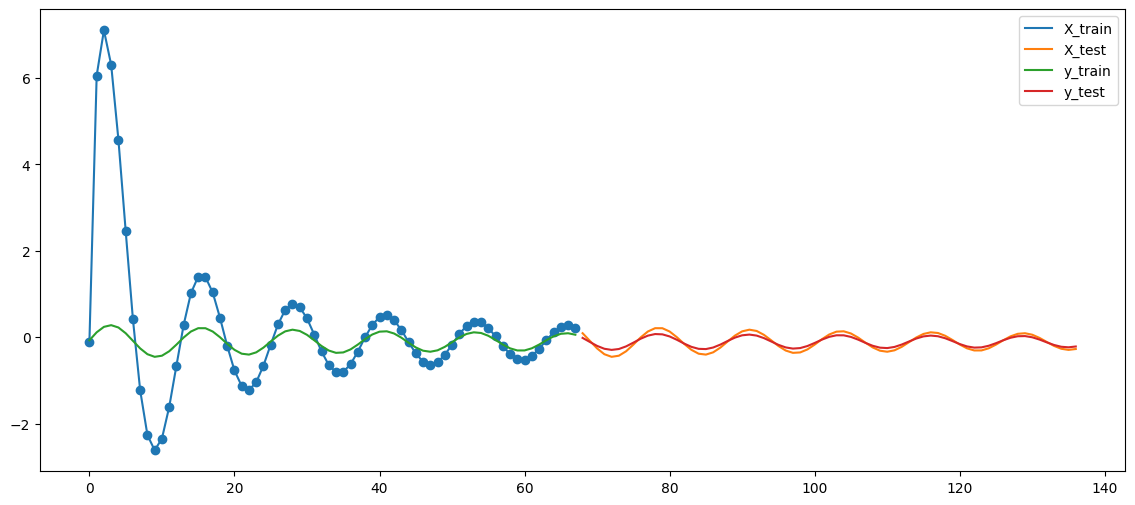

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import torch


shift = round(10 * 2 * np.pi)
pre_X = np.arange(200)

# y = (13000 + 2000 * np.sin(10 + pre_X / 15))

# temp y
# y =  1000 * np.sqrt(pre_X) - (pre_X) ** 2
# y = pre_X ** 2
# y = 10 + np.sin(pre_X / 7)
# L = 10
# k = 5e-2
# x_0 = 0
# y = L / (1 + np.exp(-k * (pre_X - x_0)))
y = np.sin(pre_X / 2) / (pre_X + 1)

# temp standardize
y = (y - y.mean()) / y.std()

X = y[:-shift].reshape(-1, 1)

# X = pre_X[shift:].reshape(-1, 1)
y = y[shift:].reshape(-1, 1)

# y = y.reshape(-1, 1)
# X = pre_X.reshape(-1, 1)

NUM_DATA_PER_GROUP = X.size // 2

X_train, X_test, y_train, y_test = X[:NUM_DATA_PER_GROUP], X[NUM_DATA_PER_GROUP:], y[:NUM_DATA_PER_GROUP], y[NUM_DATA_PER_GROUP:]
X_train, X_test, y_train, y_test, X, y = map(lambda data: torch.from_numpy(data).float(), (X_train, X_test, y_train, y_test, X, y))

print("data shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


def my_plot(X_train, X_test, y_train, y_test):
    num_train_steps = X_train.shape[0]
    num_test_steps = X_test.shape[0]

    x_plot_train = np.arange(num_train_steps)
    x_plot_test = np.arange(num_train_steps, num_train_steps + num_test_steps)
    plt.figure(figsize=(14,6))
    plt.plot(x_plot_train, X_train, label='X_train')
    plt.scatter(x_plot_train, X_train)
    plt.plot(x_plot_test, X_test, label='X_test')
    plt.plot(x_plot_train, y_train, label='y_train')
    plt.plot(x_plot_test, y_test, label='y_test')
    plt.legend()
    plt.show()

my_plot(X_train, X_test, y_train, y_test)

In [117]:
# DEFs

from statsmodels.tools.eval_measures import mse
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm



def _df_to_tensor(df: pd.DataFrame, dtype=float) -> torch.Tensor:
    return torch.Tensor(df.to_numpy(dtype=dtype))

def _get_train_loader(X_train, y_train, batch_size):
    try:
        X_train, y_train = map(lambda df: _df_to_tensor(df, dtype=float), (X_train, y_train))
    except AttributeError:
        pass
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    return train_loader

def train_base_model(lr=1e-2):
    dim_in, dim_out = X_train.shape[-1], y_train.shape[-1]
    try:
        X_test_tensor = _df_to_tensor(X_test)
    except AttributeError:
        X_test_tensor = X_test

    model = model_builder(dim_in, hidden_layer_size, dim_out)

    train_loader = _get_train_loader(X_train, y_train, batch_size)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    iterable = tqdm(range(N_EPOCHS)) if verbose else range(N_EPOCHS)
    train_losses, test_losses = [], []
    for it in iterable:
        model.train()
        for loaded_X, loaded_y in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(loaded_X), loaded_y)
            loss.backward()
            optimizer.step()
        try:
            if it % train_loss_iter == 0:
                train_losses.append(loss.item())
            if it % test_loss_iter == 0:
                model.eval()
                with torch.no_grad():
                    test_preds = model(X_test_tensor)  # .detach()
                test_loss = mse(test_preds, y_test).item()
                test_losses.append(test_loss)
        except ZeroDivisionError:
            pass
    model.eval()
    base_model = model
    return base_model, train_losses, test_losses

def plot_training_progress(train_losses, test_losses):
    fig, ax = plt.subplots()
    ax.semilogy(train_losses, label='train')
    ax.semilogy(test_losses, label='test')
    ax.legend()
    plt.show()

def plot_base_performance(y_preds):
    num_train_steps, num_test_steps = X_train.shape[0], X_test.shape[0]

    x_plot_train = np.arange(num_train_steps)
    x_plot_full = np.arange(num_train_steps + num_test_steps)
    x_plot_test = np.arange(num_train_steps, num_train_steps + num_test_steps)
    x_plot_uq = x_plot_full

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))

    ax.plot(x_plot_full, y, color="black", linestyle="dashed", label="True mean")
    ax.scatter(x_plot_train, y_train, color="black", marker="o", alpha=0.8, label="training points", )
    ax.plot(x_plot_uq, y_preds, label=f"mean/median prediction")#, color="green", )

    ax.plot(x_plot_train, X_train, label='X_train')
    ax.plot(x_plot_test, X_test, label='X_test')
    ax.plot(x_plot_train, y_train, label='y_train')
    ax.plot(x_plot_test, y_test, label='y_test')

    ax.legend()
    ax.set_xlabel("data")
    ax.set_ylabel("target")
    plt.show()

100%|██████████| 1000/1000 [00:13<00:00, 76.34it/s]


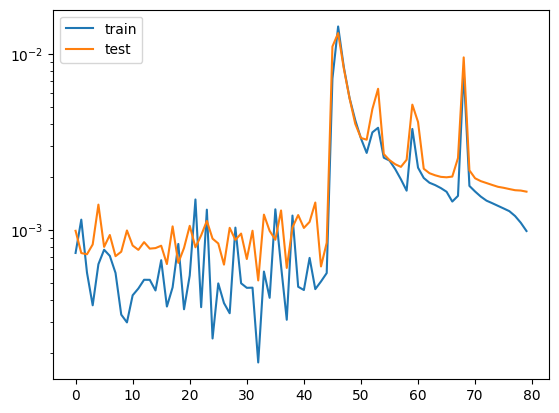

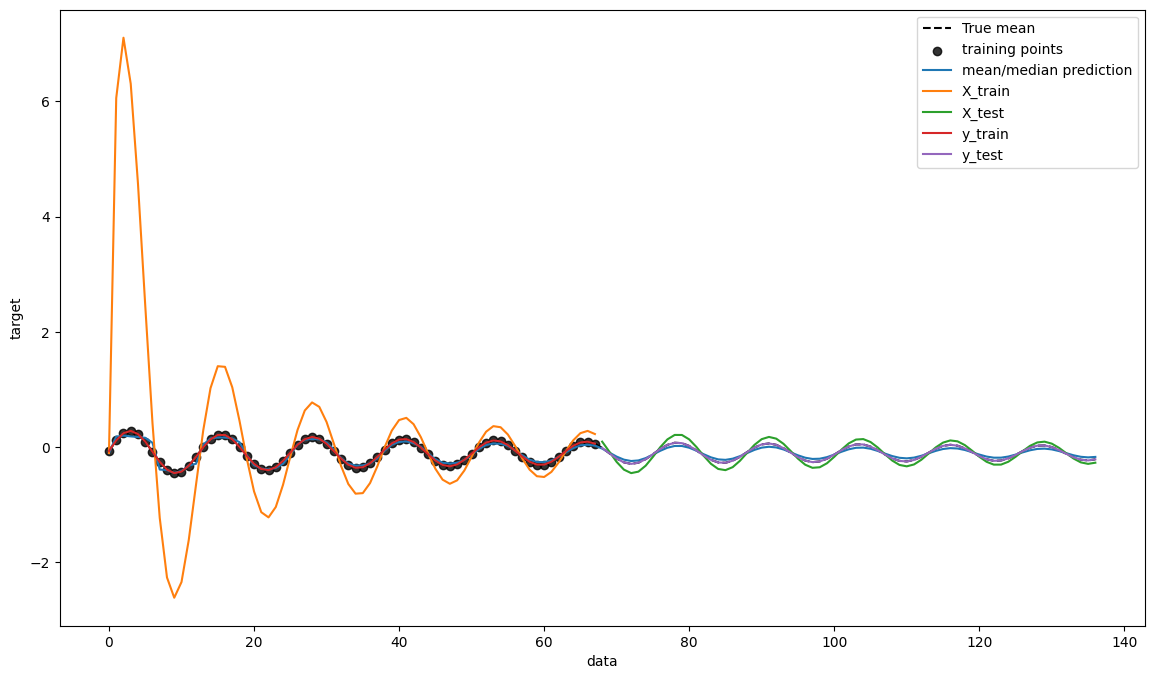

In [129]:
import more_itertools

random_state = 711
N_EPOCHS = 1000
batch_size = 10

verbose = True
hidden_layer_size = 50
num_hidden_layers = 2
activation = torch.nn.LeakyReLU

train_loss_iter = N_EPOCHS // 100
test_loss_iter = train_loss_iter

lr = 1e-2


def model_builder(dim_in, hidden_layer_size, dim_out):
    layers = [torch.nn.Linear(dim_in, hidden_layer_size), activation()]
    layers.append([
        [torch.nn.Linear(hidden_layer_size, hidden_layer_size), activation()]
        for layer in range(num_hidden_layers)
    ])
    layers.append(torch.nn.Linear(hidden_layer_size, dim_out))
    model = torch.nn.Sequential(*more_itertools.collapse(layers))
    model = model.float()
    return model

torch.manual_seed(random_state)

base_model, train_losses, test_losses = train_base_model(lr)
base_model.eval()

loss_skip = 20
plot_training_progress(train_losses[loss_skip:], test_losses[loss_skip:])


def test(X, base_model):
    X_input = X.detach()
    y_preds = base_model(X_input).detach()
    plot_base_performance(y_preds)

test(X, base_model)

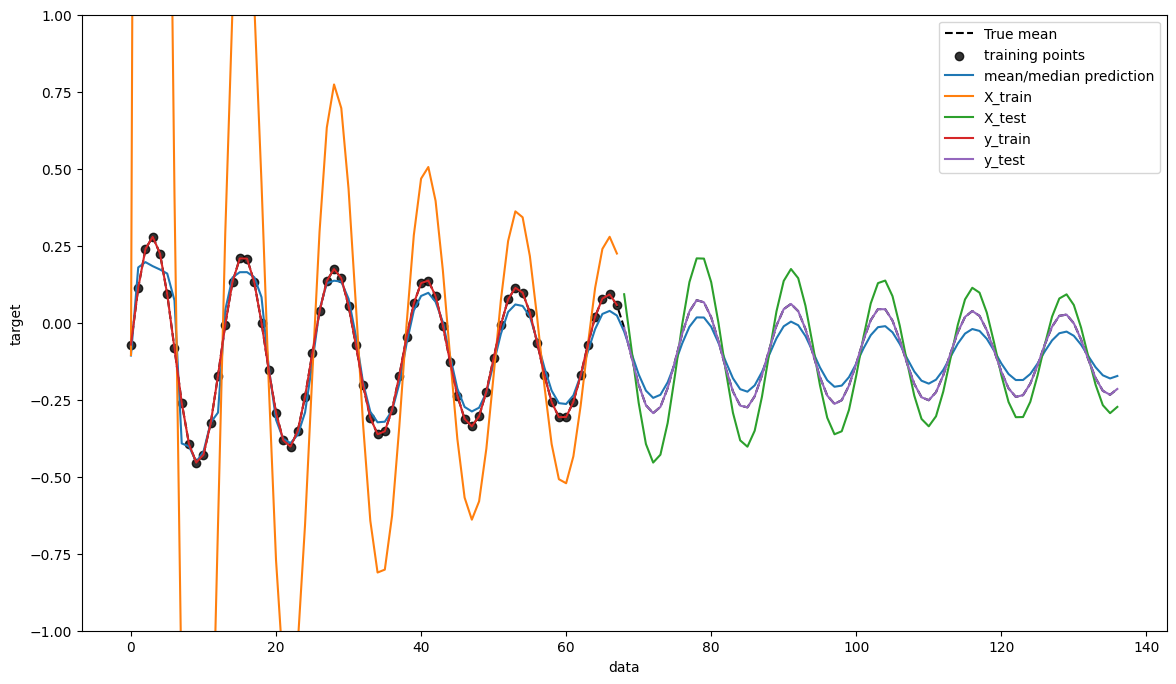

In [134]:
# PLOTS
# plot_training_progress(train_losses, test_losses)


def plot_base_performance2(y_preds):
    num_train_steps, num_test_steps = X_train.shape[0], X_test.shape[0]

    x_plot_train = np.arange(num_train_steps)
    x_plot_full = np.arange(num_train_steps + num_test_steps)
    x_plot_test = np.arange(num_train_steps, num_train_steps + num_test_steps)
    x_plot_uq = x_plot_full

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))

    ax.plot(x_plot_full, y, color="black", linestyle="dashed", label="True mean")
    ax.scatter(x_plot_train, y_train, color="black", marker="o", alpha=0.8, label="training points", )
    ax.plot(x_plot_uq, y_preds, label=f"mean/median prediction")#, color="green", )

    ax.plot(x_plot_train, X_train, label='X_train')
    ax.plot(x_plot_test, X_test, label='X_test')
    ax.plot(x_plot_train, y_train, label='y_train')
    ax.plot(x_plot_test, y_test, label='y_test')

    ax.legend()
    ax.set_xlabel("data")
    ax.set_ylabel("target")

    ymin, ymax = -1, 1
    ax.set_ylim([ymin, ymax])

    plt.show()


def test2(X, base_model):
    X_input = X.detach()
    y_preds = base_model(X_input).detach()
    plot_base_performance2(y_preds)


test2(X, base_model)